# 0. Install and Import dependencies

In [290]:
# !pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines gym-anytrading gym

In [3]:
# Gym stuff
import gymnasium as gym
import gym_anytrading

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import quantstats as qs

In [19]:
# ENV_FRAME_BOUND = (5, 250)
# WINDOW_SIZE = 5

CUSTOM_ENV_FRAME_BOUND = (12, 50)
CUSTOM_WINDOW_SIZE = 12

EVAL_ENV_FRAME_BOUND = (80, 250)
EVAL_WINDOW_SIZE = 12

# 1. Bring in Marketwatch GME Data 
https://www.marketwatch.com/investing/stock/gme/download-data?startDate=11/1/2019&endDate=03/12/2021

In [20]:
df = pd.read_csv('data/gmedata.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', ascending=True, inplace=True)
df.set_index('Date', inplace=True)
df['Volume'] = df['Volume'].apply(lambda x: float(x.replace(",", "")))
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-03-16,3.93,4.57,3.90,4.37,4866696.0
2020-03-17,4.40,4.65,4.11,4.23,3562210.0
2020-03-18,4.10,4.25,3.50,3.77,3651709.0
2020-03-19,3.71,4.20,3.55,4.19,5039539.0
2020-03-20,4.08,4.08,3.65,3.76,7722194.0


In [21]:
# env = gym.make('stocks-v0', df=df, frame_bound=ENV_FRAME_BOUND, window_size=WINDOW_SIZE)

# 1.1 Custom Data

In [22]:
# import yfinance as yf

# df = yf.Ticker("ADBE")
# df = df.history(period="max")
# df = df.loc['2022-01-01':, ['Open', 'High', 'Low', 'Close', 'Volume']]
# print(df.shape)
# df.head()

In [23]:
# window_size=20
# env = gym.make('stocks-v0', df=df, frame_bound=(window_size,len(df)), window_size=window_size)

# 2. Build Environment

In [24]:
# env.action_space

In [25]:
# state = env.reset()
# while True: 
#     action = env.action_space.sample()
#     observation, reward, terminated, truncated, info = env.step(action)
#     done = terminated or truncated
#     if done: 
#         print("info", info)
#         break
        
# plt.figure(figsize=(15,6))
# plt.cla()
# env.render_all()
# plt.show()

# 2.1 Add Custom Indicators

## 2.1.1. Install and Import New Dependencies

In [26]:
from gym_anytrading.envs import StocksEnv
from finta import TA

## 2.1.3. Calculate SMA, RSI and OBV

In [27]:
df['SMA'] = TA.SMA(df, 12)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)
df.fillna(0, inplace=True)

## 2.1.4. Create New Environments

In [28]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

In [29]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals

env2 = MyCustomEnv(df=df, frame_bound=CUSTOM_ENV_FRAME_BOUND, window_size=CUSTOM_WINDOW_SIZE)

In [30]:
# env2.signal_features

# 3. Build Environment and Train

In [31]:
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [32]:
# model = A2C('MlpPolicy', env, verbose=0) 
# model.learn(total_timesteps=10000)

In [34]:
from sb3_contrib import RecurrentPPO
model = RecurrentPPO("MlpLstmPolicy", env, verbose=0, seed=2023)
model.learn(total_timesteps=10000)

# 4. Evaluation

In [37]:
env = MyCustomEnv(df=df, frame_bound=EVAL_ENV_FRAME_BOUND, window_size=EVAL_WINDOW_SIZE)
observation, info = env.reset()
while True: 
    observation = observation[np.newaxis, ...]
    action, _states = model.predict(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        print("info", info)
        break

info {'total_reward': 33.81, 'total_profit': 1.4906194797599965, 'position': <Positions.Short: 0>}


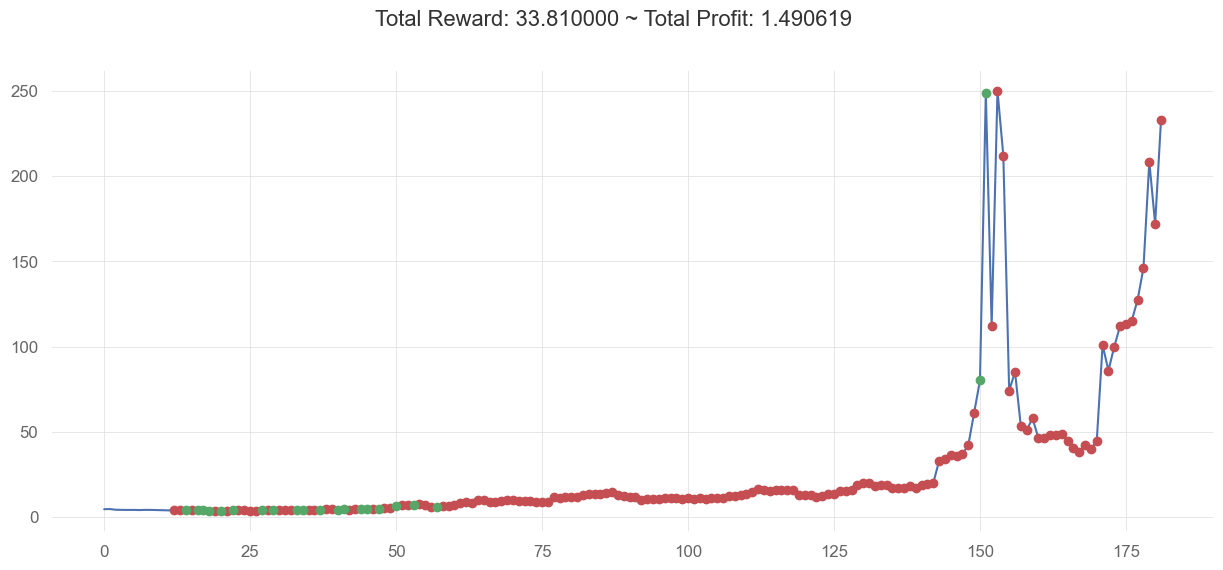

In [38]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

# 5. QuantStats

c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

                           Strategy
-------------------------  ----------
Start Period               2020-07-13
End Period                 2021-03-11
Risk-Free Rate             0.0%
Time in Market             9.0%

Cumulative Return          49.06%
CAGR﹪                     51.8%

Sharpe                     1.39
Prob. Sharpe Ratio         96.72%
Smart Sharpe               1.38
Sortino                    4.8
Smart Sortino              4.76
Sortino/√2                 3.39
Smart Sortino/√2           3.37
Omega                      3.3

Max Drawdown               -18.88%
Longest DD Days            53
Volatility (ann.)          51.01%
Calmar                     2.74
Skew                       9.6
Kurtosis                   114.27

Expected Daily %           0.24%
Expected Monthly %         4.54%
Expected Yearly %          22.09%
Kelly Criterion            41.8%
Risk of Ruin               0.0%
Daily Value-at-Risk        -5.0%
Expected Shortfall (cVaR)  -5.0%

Max Consecutive Wins       1
Max

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-07-14,2020-07-31,2020-09-04,53,-18.881006,-18.062654


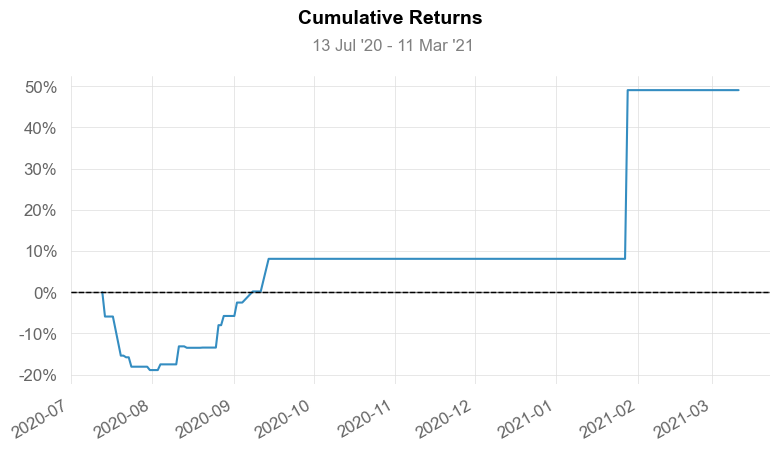

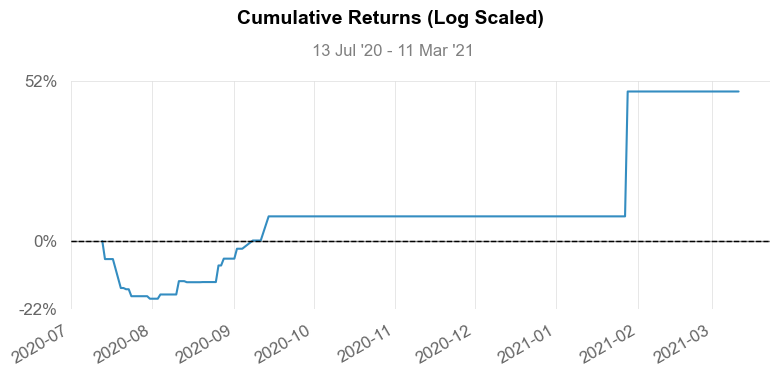

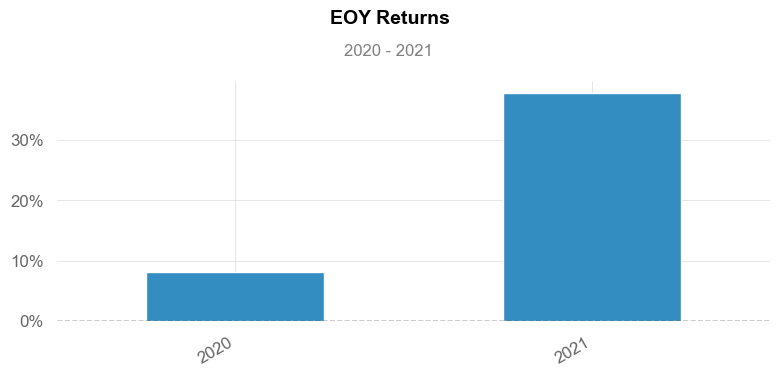

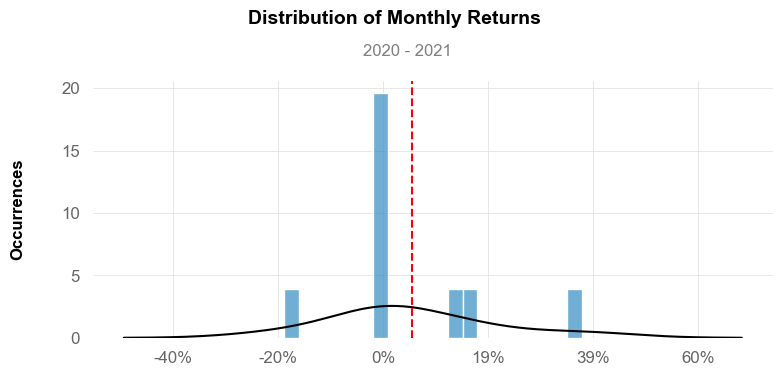

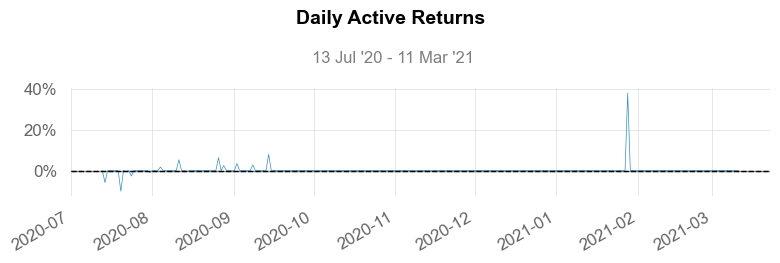

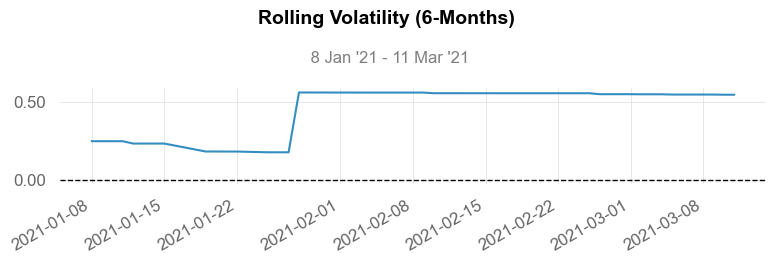

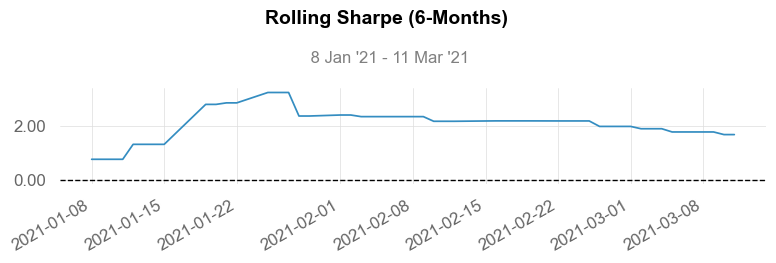

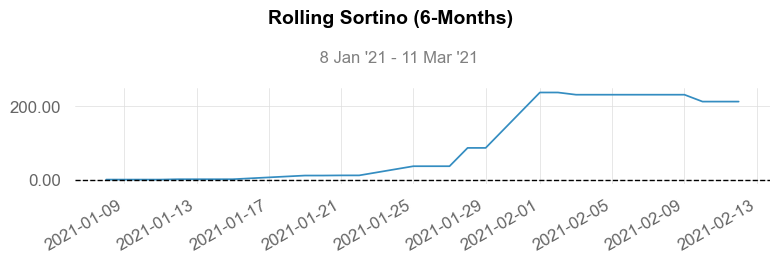

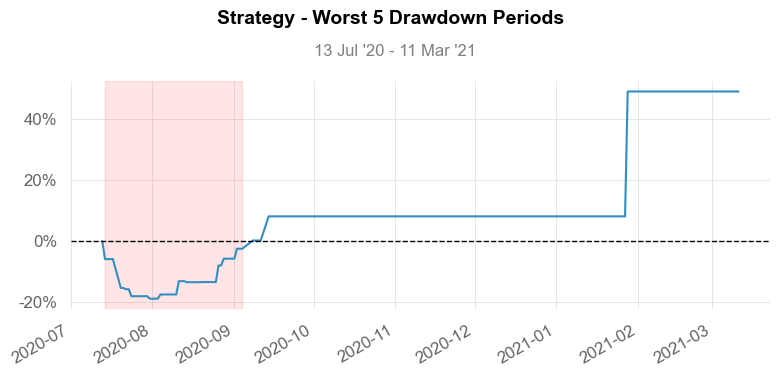

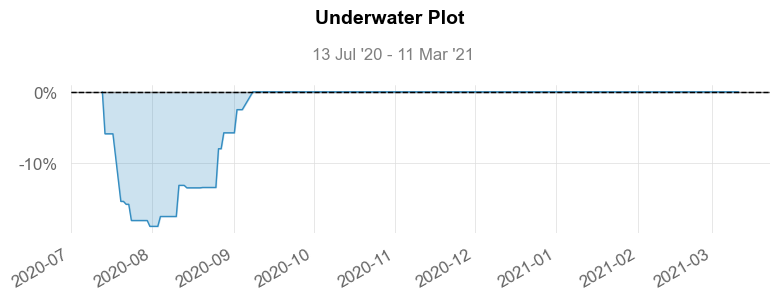

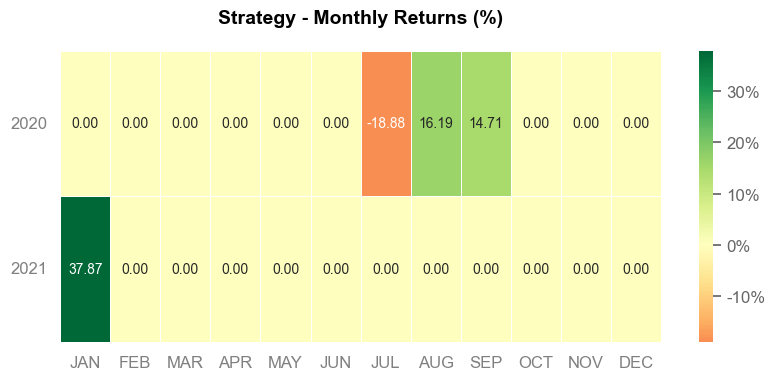

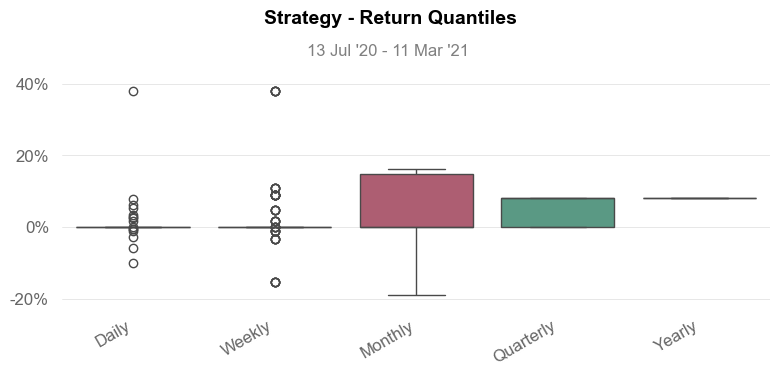

In [39]:
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[EVAL_ENV_FRAME_BOUND[0]+1:EVAL_ENV_FRAME_BOUND[1]])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)